In [1]:
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize, imread, imsave
import numpy as np
import cv2
import matplotlib.pyplot as plt


def gkern2(kernlenx=21, kernleny=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlenx, kernleny))
    # set element at the middle to one, a dirac delta
    inp[kernlenx//2, kernleny//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    return gaussian_filter(inp, nsig)

# g_2d = gkern2(160, 160, 80)
# plt.imshow(g_2d, interpolation='none')
# g_2d = imresize(g_2d, (160, 80))
# g_2d = np.stack((g_2d, g_2d, g_2d), 2)
# plt.imshow(g_2d, interpolation='none')

# box_2d = np.zeros((160,80))
# box_2d[20:140, 10:70] = 1
# box_2d = np.stack((box_2d, box_2d, box_2d), 2)
# plt.imshow(box_2d, interpolation='none')

In [2]:
#####################
# clustering method #
#####################
import os
from matplotlib.colors import rgb_to_hsv
img_dir = 'clip_imgs2'
hist_vec = None
imgs = None
color_space = 'hsv'
frame_box_list = []
for i,f in enumerate(os.listdir(img_dir)):
    if 'jpg' not in f:
        continue
    img = imread(os.path.join(img_dir, f), mode='RGB')
    frame = f.split('.')[0].split('_')[0]
    box = int(f.split('.')[0].split('_')[1][4:])
    
    frame_box_list.append({'frame':frame, 'box':box})
    if imgs is None:
        imgs = [img]
    else:
        imgs.append(img)
    c_hist_vec = None
    
#     box_2d = np.zeros(img.shape[:2])
#     box_2d[20:-20, 10:-10] = 1
#     box_2d = np.stack((box_2d, box_2d, box_2d), 2)
    
    img = img[20:-20, 10:-10]
    if color_space == 'hsv':
        img = rgb_to_hsv(img/255)
#     img = img*g_2d
    for c in range(2):
        hist, _ = np.histogram(img[:,:,c].ravel(), bins=10)
        hist = hist.astype(float)
        hist = (hist - np.min(hist))/ (np.max(hist) - np.min(hist))
        if c_hist_vec is None:
            c_hist_vec = hist
        else:
            c_hist_vec = np.vstack((c_hist_vec, hist))
#         (hist,_,_) = plt.hist(img[:,:,c].ravel(), bins=10, weights=g_2d[:,:,c].ravel())
#         print(hist)
#         plt.show()
    c_hist_vec = c_hist_vec.reshape(1, -1)
    if hist_vec is None:
        hist_vec = c_hist_vec
    else:
        hist_vec = np.vstack((hist_vec, c_hist_vec))
print(hist_vec.shape)

(2253, 20)


In [2]:
################
# query method #
################
import os
from matplotlib.colors import rgb_to_hsv
img_dir = 'clip_imgs3'
hist_vec = None
imgs = None
d_threshold = 1.75
frame_box_list = []
color_space = 'rgb'
labeled_query_file = ['output007_clip9.jpg', 'output004_clip7.jpg', 'output004_clip11.jpg']

if color_space == 'hsv':
    labeled_hist_vec = np.zeros([3, 20])
else:
    labeled_hist_vec = np.zeros([3, 30])

for i, f in enumerate(labeled_query_file):
    img = imread(os.path.join(img_dir, f), mode='RGB')
    
    c_hist_vec = None
    
    img = img[20:-20, 10:-10]
    if color_space == 'hsv':
        img = rgb_to_hsv(img/255)
    channel = 2 if color_space == 'hsv' else 3
    for c in range(channel):
        hist, _ = np.histogram(img[:,:,c].ravel(), bins=10)
        hist = hist.astype(float)
        hist = (hist - np.min(hist))/ (np.max(hist) - np.min(hist))
#         (hist,_,_) = plt.hist(img[:,:,c].ravel(), bins=10)
#         plt.show()
        if c_hist_vec is None:
            c_hist_vec = hist
        else:
            c_hist_vec = np.vstack((c_hist_vec, hist))

    c_hist_vec = c_hist_vec.reshape(1, -1)
    labeled_hist_vec[i] = c_hist_vec

group = []

for i,f in enumerate(os.listdir(img_dir)):
    if 'jpg' not in f:
        continue
    img = imread(os.path.join(img_dir, f), mode='RGB')
    frame = f.split('.')[0].split('_')[0]
    box = int(f.split('.')[0].split('_')[1][4:])
    
    frame_box_list.append({'frame':frame, 'box':box})
    if imgs is None:
        imgs = [img]
    else:
        imgs.append(img)
    c_hist_vec = None
    
    img = img[20:-20, 10:-10]
    if color_space == 'hsv':
        img = rgb_to_hsv(img/255)
    channel = 2 if color_space == 'hsv' else 3
    for c in range(channel):
        hist, _ = np.histogram(img[:,:,c].ravel(), bins=10)
        hist = hist.astype(float)
        hist = (hist - np.min(hist))/ (np.max(hist) - np.min(hist))
        if c_hist_vec is None:
            c_hist_vec = hist
        else:
            c_hist_vec = np.vstack((c_hist_vec, hist))
    c_hist_vec = c_hist_vec.reshape(1, -1)
    d = np.linalg.norm(labeled_hist_vec-c_hist_vec, axis=1)
    min_index = np.argmin(d)
    group.append(min_index)
#     if d[min_index] < d_threshold:
#         group.append(min_index)
#     else:
#         group.append(3)

In [3]:
print(hist_vec.shape)
from sklearn.cluster import KMeans, DBSCAN

kmeans = KMeans(n_clusters=4, random_state=0, n_jobs=-1)
# dbscan = DBSCAN(eps=0.15, min_samples=5)

cluster_result = kmeans.fit(hist_vec)

(2253, 20)


5


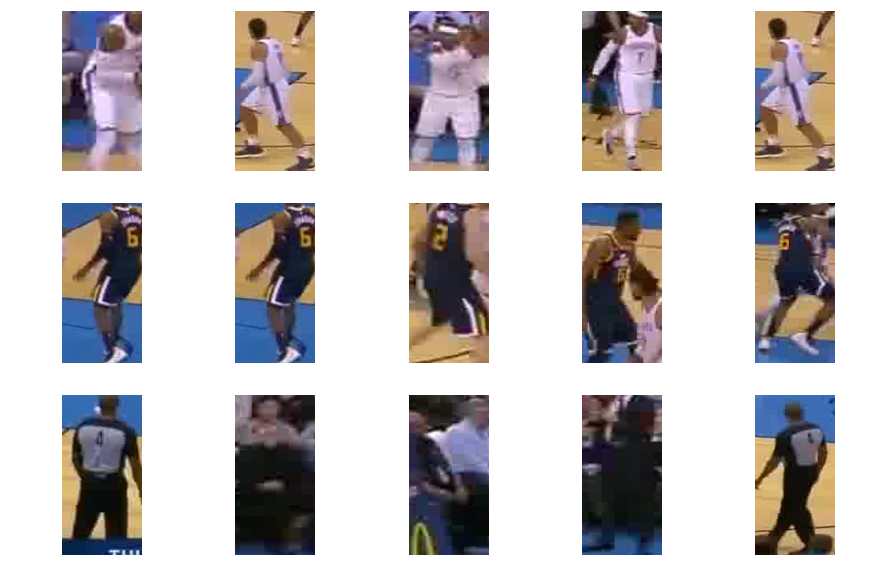

In [5]:
# group = cluster_result.predict(hist_vec)


frame_class_dict = {}
img_test = [[],[],[]]
for need_g in range(len(np.unique(group))):
#     fig = plt.figure(figsize=(20,20))
#     plt.suptitle('test', fontsize=10)
#     plt.axis('off')
#     k = 1
    for i, g in enumerate(group):
#         if frame_box_list[i]['frame'] not in frame_class_dict.keys():
#             frame_class_dict[frame_box_list[i]['frame']] = {}
#         frame_class_dict[frame_box_list[i]['frame']][frame_box_list[i]['box']] = g
        if len(img_test[g]) < 5:
            img_test[g].append(imgs[i])
#         if g == need_g:
#             fig.add_subplot(20, 20, k)
#             k = k + 1
#             plt.axis('off')
#             plt.imshow(imgs[i])
#         if k == 401:
#             break
#     plt.savefig('test_group{}.jpg'.format(need_g))

img_test[0][4] = imgs[1]
img_test[1][1] = imgs[2]
fig = plt.figure(figsize=(15, 10))
plt.axis('off')
print(len(img_test[0]))
for i in range(3):
    for j in range(5):
        k = i*5 + j + 1
        fig.add_subplot(3, 5, k)
        plt.axis('off')
        plt.imshow(img_test[i][j])

plt.savefig('3_class.jpg')

In [7]:
import pickle
pickle.dump(frame_class_dict, open('query_method001.pkl','wb'))

In [19]:
group.count(2)

0